![head.png](https://github.com/cafawo/FinancialDataAnalytics/blob/master/figures/head.jpg?raw=1)

# Financial Data Analytics in Python

**Prof. Dr. Fabian Woebbeking**</br>
Assistant Professor of Financial Economics

IWH - Leibniz Institute for Economic Research</br>
MLU - Martin Luther University Halle-Wittenberg

fabian.woebbeking@iwh-halle.de

# Homework: Satellite imagery

You will need a Git/GitHub repository to submit your course deliverables. Consult [**slides.ipynb**](https://github.com/cafawo/FinancialDataAnalytics) for help with the tasks below! If you need further assistance, do not hesitate to open a Q&A at https://github.com/cafawo/FinancialDataAnalytics/discussions

In [ ]:
# Packages used in this notebook
import ee
import geemap
import matplotlib.pyplot as plt
import numpy as np

### Task:

Set up a google earth engine workflow to display satellite images of a location (or region) of your choosing.

In [1]:
import ee
import geemap

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Define the region of interest (ROI) as Mumbai
mumbai = ee.Geometry.Point([72.8777, 19.0760])  # Coordinates for Mumbai

# Load a Landsat 8 image collection
collection = ee.ImageCollection('LANDSAT/LC08/C01/T1_TOA') \
              .filterDate('2023-01-01', '2023-12-31') \
              .filterBounds(mumbai)

# Get the median image
image = collection.median()

# Select the bands to display (e.g., Red, Green, Blue)
bands = ['B4', 'B3', 'B2']

# Create a map centered on Mumbai
Map = geemap.Map(center=[19.0760, 72.8777], zoom=10)

# Add the image to the map
Map.addLayer(image, {'bands': bands, 'min': 0, 'max': 3000}, 'Landsat 8 Image of Mumbai')

# Display the map
Map

/home/codespace/.python/current/lib/python3.10/site-packages/ee/deprecation.py:204: DeprecationWarning: 

Attention required for LANDSAT/LC08/C01/T1_TOA! You are using a deprecated asset.
To ensure continued functionality, please update it by July 1, 2024.
Learn more: https://developers.google.com/earth-engine/landsat_c1_to_c2

  warnings.warn(warning, category=DeprecationWarning)


Map(center=[19.076, 72.8777], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

### Task:

Show a time series plot of the average summer temperature in celsius at your location. To do so, choose a relevant data sets from: https://developers.google.com/earth-engine/datasets/

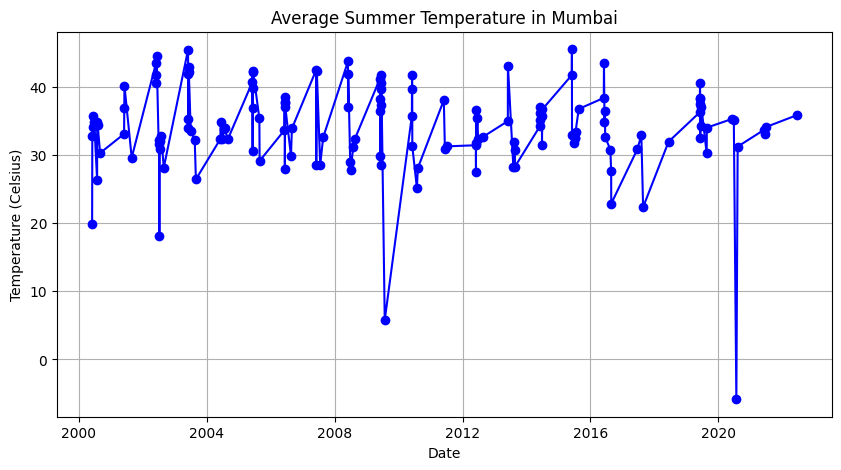

In [3]:
import ee
import geemap
import matplotlib.pyplot as plt
import pandas as pd

# Initialize the Earth Engine module.
ee.Initialize()

# Define the region of interest (Mumbai)
mumbai = ee.Geometry.Point([72.8777, 19.0760])

# Load the MODIS Land Surface Temperature dataset
dataset = ee.ImageCollection('MODIS/006/MOD11A1') \
            .filterBounds(mumbai) \
            .filter(ee.Filter.calendarRange(6, 8, 'month'))  # Filter for summer months (June, July, August)

# Select the daytime land surface temperature band (LST_Day_1km)
temperature = dataset.select('LST_Day_1km')

# Convert temperature from Kelvin to Celsius
def kelvin_to_celsius(image):
    return image.multiply(0.02).subtract(273.15).copyProperties(image, ['system:time_start'])

temperature_celsius = temperature.map(kelvin_to_celsius)

# Calculate the average temperature for each image
def get_mean_temperature(image):
    mean_dict = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=mumbai,
        scale=1000,
        maxPixels=1e9
    )
    mean_temp = mean_dict.get('LST_Day_1km')
    return ee.Feature(None, {'mean_temp': mean_temp, 'date': image.date().format()})

mean_temp_features = temperature_celsius.map(get_mean_temperature).filter(ee.Filter.notNull(['mean_temp']))

# Convert to a list of dictionaries
mean_temp_list = mean_temp_features.getInfo()['features']

# Extract dates and temperatures
dates = [pd.to_datetime(feature['properties']['date']) for feature in mean_temp_list]
temps = [feature['properties']['mean_temp'] for feature in mean_temp_list]

# Create a DataFrame
df = pd.DataFrame({'Date': dates, 'Temperature (C)': temps})

# Plot the time series
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Temperature (C)'], marker='o', linestyle='-', color='b')
plt.title('Average Summer Temperature in Mumbai')
plt.xlabel('Date')
plt.ylabel('Temperature (Celsius)')
plt.grid(True)
plt.show()

### Task:

Discuss potential data quality issues and solutions. Do the results (temperatures) change if you employ a BAP composition? Add another line to the time series plot, displaying temperatures extracted from the BAP composites.